## Implementation and Analysis of GPT-2 

Key points:

- Follow the original GPT-2 design of using both token and positional embeddings.
- Implement the transformer layers with multi-head self-attention and point-wise feed-forward network.
- You're required to abstain from using pre-built transformer libraries.

---
### Discussion :
As given in the assignment I have used three resources for the implemtations of this task <br>
1. GPT-2 Paper: https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf 
2. nanoGPT: https://github.com/karpathy/nanoGPT
3. A Beginner's Guide to Natural Language Processing: https://youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&feature=shared

#### Sub-Task 1 : Creating the model

In [4]:
# Importing Required Libraries
import math
import time
import inspect
import requests
import os
import pickle
import numpy as np
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

import tiktoken
# from bpemb import BPEmb
from contextlib import nullcontext


from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
from transformers import load_tf_weights_in_gpt2
from transformers.utils import CONFIG_NAME, WEIGHTS_NAME
from transformers import GPT2Tokenizer

# if all libraries are imported successfully, then the following line will be printed
if __name__ == "__main__":
    print("All libraries imported successfully!")

All libraries imported successfully!


In [5]:
# Implimentation of individual components of the model

    # Layer Normalization 

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)
    
    # Causal Self Attention

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y
    
    # Multi Layer Perceptron
    
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x
    
    # Single tansformer decoder block
    
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x
    



In [6]:
# Implimentation of the model

    # Configuration of the model

@dataclass    
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

    # Defining the GPT model

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss
    
    def from_pretrained(model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

We have now defined the GPT model.  
This Implementation has been done using Pytorch without the use of any pre-built transformer libraries.    
Please Note that much of the Code has been referenced from the NanoGPT Repository.


---

#### Sub-Task 2 : Instantiate and load checkpoints
We will now instatiate the Model and load the checkpoints. 

In [7]:
# Defining Model Parameters

n_layer = 12
n_head = 12
n_embd = 768
block_size = 1024
bias = False
device = 'cuda'
init_from = 'gpt2' # can be scratch or from checkpoint
out_dir = r'./checkpoints' # directory to save the trained model, for resuming training later.
dropout = 0 # 0 for pretraining and >0.1 for finetuning and other tasks

model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=50257, dropout=dropout) # start with model_args from command line

meta_vocab_size = None # if None, defaults to the full vocab size

# Definining GPTModelInitializer which initializes the model based on whether we are training from scratch, resuming from previous checkpoint or loading pre-trained weights by OpenAI.

class GPTModelInitializer:
    def __init__(self, init_from, model_args ,meta_vocab_size=None, out_dir=None, device=None, dropout=0.1):
        self.init_from = init_from
        self.model_args = model_args
        self.meta_vocab_size = meta_vocab_size
        self.out_dir = out_dir
        self.device = device
        self.dropout = dropout
        self.checkpoint = None

    def initialize_model(self):
        if self.init_from == 'scratch':
            print("Initializing a new model from scratch")
            if self.meta_vocab_size is None:
                print("defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)")
            self.model_args['vocab_size'] = self.meta_vocab_size if self.meta_vocab_size is not None else 50304
            gptconf = GPTConfig(**self.model_args)
            model = GPT(gptconf)
        elif self.init_from == 'resume':
            print(f"Resuming training from {self.out_dir}")
            ckpt_path = os.path.join(self.out_dir, 'ckpt.pt')
            checkpoint = torch.load(ckpt_path, map_location=self.device)
            checkpoint_model_args = checkpoint['model_args']
            for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
                self.model_args[k] = checkpoint_model_args[k]
            gptconf = GPTConfig(**self.model_args)
            model = GPT(gptconf)
            state_dict = checkpoint['model']
            unwanted_prefix = '_orig_mod.'
            for k,v in list(state_dict.items()):
                if k.startswith(unwanted_prefix):
                    state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
            model.load_state_dict(state_dict)
            iter_num = checkpoint['iter_num']
            best_val_loss = checkpoint['best_val_loss']
            self.checkpoint = checkpoint
        elif self.init_from.startswith('gpt2'):
            print(f"Initializing from OpenAI GPT-2 weights: {self.init_from}")
            override_args = dict(dropout=self.dropout)
            model = GPT.from_pretrained(self.init_from, override_args)
            for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
                self.model_args[k] = getattr(model.config, k)

        return model, self.model_args, self.checkpoint

initializer = GPTModelInitializer(init_from=init_from, model_args=model_args,meta_vocab_size=meta_vocab_size, out_dir=out_dir, device = device, dropout = dropout)
model, model_args,_ = initializer.initialize_model()


# crop down the model block size if desired, using model surgery
if block_size < model.config.block_size:
    model.crop_block_size(block_size)
    model_args['block_size'] = block_size # so that the checkpoint will have the right value

# move the model to GPU
model = model.to(device)

Initializing from OpenAI GPT-2 weights: gpt2
loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0


number of parameters: 123.65M


Now we have instantiated the model and loaded the checkpoint, next we can print the architecture.

In [8]:
# Print the model summary

print(model)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0, inplace=False)
          (resid_dropout): Dropout(p=0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


#### Sub-Task 3 : Run Sample Prediction

We will now run a sample prediction.

In [9]:
model.eval()        # put in eval mode so that things like dropout are properly configured
num_samples = 1     # number of samples to generate from the model
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8       # temperature is the randomness in the distribution. 0.8 is a good value to get diverse responses.
top_k = 200             # top_k constrains the generated guesses to the top k guesses
start = "hey I am shaurya  , I am interseted in deep learning" # can be any string
enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)


# run generation , roughly takes 45s on NVIDIA GeForce GTX 1660 Ti 
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')



hey I am shaurya  , I am interseted in deep learning, but I am not to take the liberty of making the best of it.

I am going to give the word "big time" in it to the big guy. And it is to get me to look down and see that with regard to the things I am doing, I am not being selfish. I am doing it to get my way, do what I love. I am doing it to get my way.

My wife is a very bright, very smart person. She lives near me in Kolliyasya, and I love her. My son is extremely intelligent. We have a child together and I love his IQ. I think that with all respect, I am wrong. I have to give nothing to this child. If I could, I would give nothing.

I am not interested in being a failure. I am interested in being a success, as much as I am interested in the fact that I will be happy.

I am not going to give anything in return. I will make the best of it.

I am not going to make anything from my savings. I will save.

I am not going to contribute anything. I will contribute nothing to this group.

I

Hopefully it will look something like this

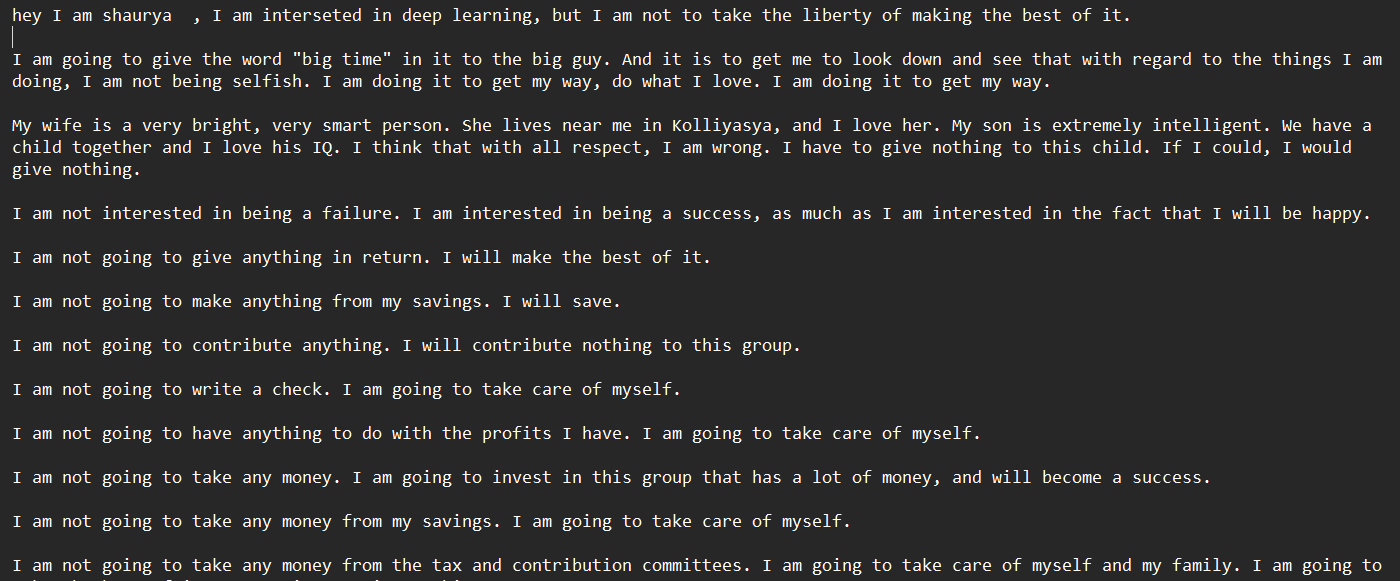

#### Conclusion of Task
This Concludes Task, we have successfully implemented the architecture of GPT-2 using PyTorch.  
Further, We have Loaded the weights through pre-existing checkpoints and ran a sample prediction. 

---

## Training Loop Implementation 
Finally, create a training loop considering these following requirements:

1. *Single GPU Training Loop:* Your base implementation should be equipped to train your model on a single GPU setup.
2. *Distributed Data Parallel (DDP):* Extend your single GPU training loop to support training across multiple GPUs using DDP. for guidance.
3. *Fully Sharded Data Parallel (FSDP):* Implement FSDP as a part of your training loop to shard the model parameters, gradients, and optimizer state.

---

### Discussion :
As given in the assignment I have used three resources for the implemtations of this task <br>

1. PyTorch's DDP tutorial: https://pytorch.org/tutorials/intermediate/ddp_tutorial.html
2. Gupta et al., 2020, Training GPT-3 Like Models on a Single Machine: https://arxiv.org/pdf/2101.06840.pdf
3. nanoGPT: https://github.com/karpathy/nanoGPT

##### Download Data

In [10]:
"""
Prepare the Shakespeare dataset for character-level language modeling.
So instead of encoding with GPT-2 BPE tokens, we just map characters to ints.
Will save train.bin, val.bin containing the ids, and meta.pkl containing the
encoder and decoder and some other related info.
"""
# if data folder doesn't exist, create it

data_path = r'./data'
if not os.path.exists(data_path):
    os.mkdir(data_path)

input_path = r'./data/shakespeare_char/' 
if not os.path.exists(input_path):
    os.mkdir(input_path)

# download the tiny shakespeare dataset
input_file_path = os.path.join(os.path.dirname(input_path), 'input.txt')
if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = encode(train_data)
val_ids = encode(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
train_ids.tofile(os.path.join(os.path.dirname(input_path), 'train.bin'))
val_ids.tofile(os.path.join(os.path.dirname(input_path), 'val.bin'))

# save the meta information as well, to help us encode/decode later
meta = {
    'vocab_size': vocab_size,
    'itos': itos,
    'stoi': stoi,
}
with open(os.path.join(os.path.dirname(input_path), 'meta.pkl'), 'wb') as f:
    pickle.dump(meta, f)

# length of dataset in characters:  1115394
# all the unique characters:
#  !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
# vocab size: 65
# train has 1003854 tokens
# val has 111540 tokens

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


##### Start Training

In [11]:
# default config values designed to train a gpt2 (124M) on Shakespeare

# I/O
out_dir = r'./checkpoints'
eval_interval = 2000
log_interval = 1
eval_iters = 200
eval_only = False # if True, script exits right after the first eval
always_save_checkpoint = True # if True, always save a checkpoint after each eval
init_from = 'scratch' # 'scratch' or 'resume' or 'gpt2*'

n_layer = 12
n_head = 12
n_embd = 768
block_size = 1024
bias = False
dropout = 0.0

# data
dataset = 'shakespeare_char' 
gradient_accumulation_steps = 5 * 8 # used to simulate larger batch sizes
batch_size = 12 # if gradient_accumulation_steps > 1, this is the micro-batch size
block_size = 1024

# adamw optimizer
learning_rate = 6e-4 # max learning rate
max_iters = 600000 # total number of training iterations
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0

# learning rate decay settings
decay_lr = True # whether to decay the learning rate
warmup_iters = 2000 # how many steps to warm up for
lr_decay_iters = 600000 # should be ~= max_iters per Chinchilla
min_lr = 6e-5 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla

# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = False # use PyTorch 2.0 to compile the model to be faster

# # -----------------------------------------------------------------------------
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
# exec(open('configurator.py').read()) # overrides from command line or config file
config = {k: globals()[k] for k in config_keys} # will be useful for logging
# # -----------------------------------------------------------------------------



In [12]:
# various inits, derived attributes, I/O setup

master_process = True
seed_offset = 42

tokens_per_iter = gradient_accumulation_steps * batch_size * block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)


tokens per iteration will be: 491,520


In [13]:
# poor man's data loader
data_dir = os.path.join('data', dataset)
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


In [14]:
# attempt to derive vocab_size from the dataset
meta_path = os.path.join(data_dir, 'meta.pkl')
meta_vocab_size = None
if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    meta_vocab_size = meta['vocab_size']
    print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")

# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout) # start with model_args from command line

class GPTModelInitializer:
    def __init__(self, init_from, model_args ,meta_vocab_size=None, out_dir=None, device=None, dropout=0.1):
        self.init_from = init_from
        self.model_args = model_args
        self.meta_vocab_size = meta_vocab_size
        self.out_dir = out_dir
        self.device = device
        self.dropout = dropout
        self.checkpoint = None

    def initialize_model(self):
        if self.init_from == 'scratch':
            print("Initializing a new model from scratch")
            if self.meta_vocab_size is None:
                print("defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)")
            self.model_args['vocab_size'] = self.meta_vocab_size if self.meta_vocab_size is not None else 50304
            gptconf = GPTConfig(**self.model_args)
            model = GPT(gptconf)
        elif self.init_from == 'resume':
            print(f"Resuming training from {self.out_dir}")
            ckpt_path = os.path.join(self.out_dir, 'ckpt.pt')
            checkpoint = torch.load(ckpt_path, map_location=self.device)
            checkpoint_model_args = checkpoint['model_args']
            for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
                self.model_args[k] = checkpoint_model_args[k]
            gptconf = GPTConfig(**self.model_args)
            model = GPT(gptconf)
            state_dict = checkpoint['model']
            unwanted_prefix = '_orig_mod.'
            for k,v in list(state_dict.items()):
                if k.startswith(unwanted_prefix):
                    state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
            model.load_state_dict(state_dict)
            iter_num = checkpoint['iter_num']
            best_val_loss = checkpoint['best_val_loss']
            self.checkpoint = checkpoint
        elif self.init_from.startswith('gpt2'):
            print(f"Initializing from OpenAI GPT-2 weights: {self.init_from}")
            override_args = dict(dropout=self.dropout)
            model = GPT.from_pretrained(self.init_from, override_args)
            for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
                self.model_args[k] = getattr(model.config, k)

        return model, self.model_args, self.checkpoint


initializer = GPTModelInitializer(init_from=init_from, model_args=model_args,meta_vocab_size=meta_vocab_size, out_dir=out_dir, device = device, dropout = dropout)
model, model_args, checkpoint= initializer.initialize_model()

# crop down the model block size if desired, using model surgery
if block_size < model.config.block_size:
    model.crop_block_size(block_size)
    model_args['block_size'] = block_size # so that the checkpoint will have the right value
model = model.to(device)

found vocab_size = 65 (inside data\shakespeare_char\meta.pkl)
Initializing a new model from scratch


number of parameters: 85.00M


In [15]:
# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# initializing num iter and best val loss for scratch training, will get overwritten if resuming
iter_num = 0
best_val_loss = 1e9

# optimizer

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=weight_decay)

if init_from == 'resume':
    optimizer.load_state_dict(checkpoint['optimizer'])
    iter_num = checkpoint['iter_num']
    best_val_loss = checkpoint['best_val_loss']
checkpoint = None # free up memory


In [16]:
# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)



In [17]:
# training loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
# local_iter_num = 0 # number of iterations in the lifetime of this process

running_mfu = -1.0 
while True:

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):

        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        # get loss as float. note: this is a CPU-GPU sync point
        # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
        lossf = loss.item() * gradient_accumulation_steps
        # if local_iter_num >= 5: # let the training loop settle a bit
        #     mfu = model.estimate_mfu(batch_size * gradient_accumulation_steps, dt)
        #     running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms%")
    iter_num += 1
    # local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break


step 0: train loss 4.3479, val loss 4.3516
iter 0: loss 4.3397, time 3531509.68ms%
